In [1]:
import os
import numpy as np
import pickle
import random
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.base import BaseEstimator, RegressorMixin
from matplotlib import pyplot as plt
from time import perf_counter
import pandas as pd

'''
Utility Code to read the data from file and shuffle it
'''


def folder_list(path,label):
    filelist = os.listdir(path)
    review = []
    labels = []
    for infile in filelist:
        file = os.path.join(path,infile)
        r = read_data(file)
        labels.append(label)
        review.append(r)
    return review , labels

def read_data(file):
    '''
    Read each file into a list of strings. 
    Example:
    ["it's", 'a', 'curious', 'thing', "i've", 'found', 'that', 'when', 'willis', 'is', 'not', 'called', 'on', 
    ...'to', 'carry', 'the', 'whole', 'movie', "he's", 'much', 'better', 'and', 'so', 'is', 'the', 'movie']
    '''
    f = open(file)
    lines = f.read().split(' ')
    symbols = '${}()[].,:;+-*/&|<>=~" '
    words = map(lambda Element: Element.translate(str.maketrans("", "", symbols)).strip(), lines)
    # For python 3 users: use the following instead
    words = list(filter(None, words))
    #words = filter(None, words)
    return words


def shuffle_data():
    pos_path = "data/pos"
    neg_path = "data/neg"
    pos_review, pos_Label = folder_list(pos_path,1)
    neg_review, neg_Label = folder_list(neg_path,-1)
    x_train_pos = pos_review[0:750]
    y_train_pos = pos_Label[0:750]
    x_test_pos = pos_review[750:1000]
    y_test_pos = pos_Label[750:1000]
    x_train_neg = neg_review[0:750]
    y_train_neg = neg_Label[0:750]
    x_test_neg = neg_review[750:1000]
    y_test_neg = neg_Label[750:1000]
    x_train_ex = x_train_pos + x_train_neg
    x_test_ex = x_test_pos + x_test_neg
    y_train_ex = y_train_pos + y_train_neg
    y_test_ex = y_test_pos + y_test_neg
    train_zipped = list(zip(x_train_ex, y_train_ex))
    test_zipped = list(zip(x_test_ex, y_test_ex))
    random.shuffle(train_zipped)
    random.shuffle(test_zipped)
    x_train, y_train = zip(*train_zipped)
    x_test, y_test = zip(*test_zipped)
    return x_train, x_test, y_train, y_test

def conv_lis_to_counter(word_list):
    sparseCounter = Counter()
    for word in word_list:
        sparseCounter[word] = sparseCounter[word] + 1
    return sparseCounter

In [3]:
'''
Utility code to handle sparse vectors
'''

def dotProduct(d1, d2):
    """
    @param dict d1: a feature vector represented by a mapping from a feature (string) to a weight (float).
    @param dict d2: same as d1
    @return float: the dot product between d1 and d2
    """
    if len(d1) < len(d2):
        return dotProduct(d2, d1)
    else:
        return sum(d1.get(f, 0) * v for f, v in d2.items())
    
def matrixMultiply(X, w):
    """
    @param list of dictionary X
    @param dict w: dictionary weight
    @return list of numbers: the dot product between X and w
    """
    outputList = []
    for x in X:
        outputList.append(dotProduct(x, w))
    return outputList

def increment(d1, scale, d2):
    """
    Implements d1 += scale * d2 for sparse vectors.
    
    NOTE: This function does not return anything, but rather
    increments d1 in place. We do this because it is much faster to
    change elements of d1 in place than to build a new dictionary and
    return it.
    """
    for f, v in d2.items():
        d1[f] = d1.get(f, 0) + v * scale

In [7]:
class SVM_Pegasos(BaseEstimator, RegressorMixin):
    "SVM. This implementation is optimized for sparse feature data, for example, in our case text "

    def __init__(self, l2reg=1, max_steps = 100):
        if l2reg < 0:
            raise ValueError('Regularization penalty should be at least 0.')
        self.l2reg_ = l2reg
        self.max_steps_ = max_steps
        
    #Does Stochastic Subgradient Descent on data X
    def pegasos_optimize(self,X, y):
        steps = 0
        epochs = 0
        n = len(y)
        del_loss = 1000000000
        prev_loss = 1000000000
        
        #While not converged
        while not(epochs >= self.max_steps_ or np.abs(del_loss) <= 10**-6):
            #shuffle the data (because sgd needs random data)
            order_vec = np.arange(0,n)
            np.random.shuffle(order_vec)
            
            for j in order_vec:
                steps = steps + 1
                #stepsize
                eta_t = 1.0/(self.l2reg_ * steps)
                cond = y[j] * dotProduct(self.w_, X[j])
                increment(self.w_,  - (eta_t * self.l2reg_), self.w_)
                
                if cond < 1:
                    increment(self.w_, eta_t * y[j], X[j])
                    
            curr_loss = self.svm_obj_(self.w_)
            del_loss = prev_loss - curr_loss
            prev_loss = curr_loss
            epochs = epochs + 1
            print("Epoch #: ", epochs, " ,Loss: ", curr_loss)
            
        return curr_loss            
        

    def fit(self, X, y):
        n = len(X)
        #Initialize weights to zero in SVM
        self.w_ = Counter()
        
        #Objective function for SVM (Hinge loss + L2 reg)
        def svm_obj(w):
            average_hinge_loss = self.empirical_loss(X, y, w)
            regLoss = (self.l2reg_/2) * dotProduct(w,w)
            objective = average_hinge_loss + regLoss
            return objective
        
        self.svm_obj_ = svm_obj
        self.minLoss_ = self.pegasos_optimize(X, y)
        return self

    def predict(self, X, w = None):
        #Predicting the sign of classification
        #if class is sign(xiTW). 
        #this function just returns xiTW
        try:
            getattr(self, "w_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")
        
        if w == None:
            return matrixMultiply(X,self.w_)
        else :
            return matrixMultiply(X, w)
    
    def empirical_loss(self, X, y, w):
        #Average Hinge loss
        losses = map(lambda predict, actual : max(0, 1 - (predict*actual)) , self.predict(X, w),  y)
        return sum(losses)/len(y)

    def score(self, X, y):
        return self.empirical_loss(X, y, self.w_)

In [8]:
class Fast_Pegasos(BaseEstimator, RegressorMixin):
    "This is much faster implementation of the same above algorithm. The trick has been taken from, https://leon.bottou.org/papers/bottou-tricks-2012"

    def __init__(self, l2reg=1, max_steps = 100):
        if l2reg < 0:
            raise ValueError('Regularization penalty should be at least 0.')
        self.l2reg_ = l2reg
        self.max_steps_ = max_steps
        
    #Does same stochastic subgradient descent, but much faster
    def pegasos_optimize(self,X, y):
        steps = 0
        epochs = 0
        n = len(y)
        del_loss = 1000000000
        prev_loss = 1000000000
        
        while not(epochs >= self.max_steps_ or np.abs(del_loss) <= 10**-6):
            order_vec = np.arange(0,n)
            np.random.shuffle(order_vec)
            
            for j in order_vec:
                steps = steps + 1
                eta_t = 1.0/(self.l2reg_ * steps)
                
                cond = y[j] * self.s_ * dotProduct(self.W_, X[j])
                self.s_ = (1 - (eta_t * self.l2reg_)) * self.s_
                
                if self.s_ == 0:
                    self.s_ = 1
                    self.W_ = Counter()
                
                if cond < 1:
                    increment(self.W_, (eta_t * y[j])/self.s_, X[j])
            
            curr_weight = Counter()
            increment(curr_weight, self.s_, self.W_)
            curr_loss = self.svm_obj_(curr_weight)
            del_loss = prev_loss - curr_loss
            prev_loss = curr_loss
            epochs = epochs + 1
            print("Epoch #: ", epochs, " ,Loss: ", curr_loss)
            
        return curr_loss            
        

    def fit(self, X, y):
        n = len(X)
        self.W_ = Counter()
        self.s_ = 1
        
        #SVM objecctive function (Hingle + L2 reg)
        def svm_obj(w):
            average_hinge_loss = self.empirical_loss(X, y, w)
            regLoss = (self.l2reg_/2) * dotProduct(w,w)
            objective = average_hinge_loss + regLoss
            return objective
        
        self.svm_obj_ = svm_obj
        self.minLoss_ = self.pegasos_optimize(X, y)
        return self

    def predict(self, X, w = None):
        #Predicting the sign of classification
        #if class is sign(xiTW). 
        #this function just returns xiTW
        try:
            getattr(self, "W_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")
        
        if w == None:
            return [ele * self.s_ for ele in matrixMultiply(X,self.W_)] 
        else :
            return matrixMultiply(X, w)
    
    def empirical_loss(self, X, y, w = None):
        #Average Hinge loss
        losses = map(lambda predict, actual : max(0, 1 - (predict*actual)) , self.predict(X, w),  y)
        return sum(losses)/len(y)
    
    def percentError(self, X, y):
        predictions = np.sign(self.predict(X))
        y_s = 1 * (predictions*y < 0)
        return (np.sum(y_s)*100)/len(y)

    def score(self, X, y):
        return self.empirical_loss(X, y)

Prepare the data and shuffle it

In [10]:
x_train, x_test, y_train, y_test = shuffle_data()

In [11]:
x_train = list(map(lambda x : conv_lis_to_counter(x), x_train ))
x_test = list(map(lambda x: conv_lis_to_counter(x), x_test))

Fit SVM through the data. Print final Train loss, Validation loss and 1 - accuracy on Validation set

In [12]:
starttime = perf_counter()
svm_class = SVM_Pegasos(l2reg = 1, max_steps=10)
svm_class.fit(x_train, y_train)
train_loss = svm_class.score(x_train, y_train)
val_loss = svm_class.score(x_test, y_test)
stoptime = perf_counter()
print("total time taken: ")
print(stoptime - starttime)
print('Train loss: ', train_loss)
print('Val loss: ', val_loss)

Epoch #:  1  ,Loss:  0.8192282222224248
Epoch #:  2  ,Loss:  1.0093478333332853
Epoch #:  3  ,Loss:  0.6486795308642594
Epoch #:  4  ,Loss:  0.5427568888888519
Epoch #:  5  ,Loss:  0.530447395555745
Epoch #:  6  ,Loss:  0.5400861604938498
Epoch #:  7  ,Loss:  0.5142757641724737
Epoch #:  8  ,Loss:  0.6407346701389431
Epoch #:  9  ,Loss:  0.5279577448559838
Epoch #:  10  ,Loss:  0.5384809399999623
total time taken: 
214.90531152200128
Train loss:  0.38518239999999876
Val loss:  0.571059333333333


Fit the faster version of SVM through the data. Print final train, validation and accuracy on Validation set

In [16]:
starttime = perf_counter()
svm_fast_class = Fast_Pegasos(l2reg = 1, max_steps=10)
svm_fast_class.fit(x_train, y_train)
train_loss = svm_fast_class.score(x_train, y_train)
val_loss = svm_fast_class.score(x_test, y_test)
stoptime = perf_counter()
print("total time taken: ")
print(stoptime - starttime)
print('Train loss: ', train_loss)
print('Val loss: ', val_loss)
print('Validation accuracy: ', 100 - svm_fast_class.percentError(x_test,y_test))

Epoch #:  1  ,Loss:  1.9938297777779832
Epoch #:  2  ,Loss:  0.9701921111110506
Epoch #:  3  ,Loss:  1.0015412592593191
Epoch #:  4  ,Loss:  0.5612409305555127
Epoch #:  5  ,Loss:  0.6088683733335275
Epoch #:  6  ,Loss:  0.6946530493827328
Epoch #:  7  ,Loss:  0.5396140952382262
Epoch #:  8  ,Loss:  0.5562897187500446
Epoch #:  9  ,Loss:  0.5135503648834173
Epoch #:  10  ,Loss:  0.5168294622221905
total time taken: 
4.25846551801078
Train loss:  0.36401120000000103
Val loss:  0.5595293333333341
Validation accuracy:  78.4


Do a grid search over different L2 Regularization parameters and plot graph of Validation loss vs L2 param

In [29]:
l2regs = [0.0005 + (0.0005/10)*i for i in range(1,10)]

for l2reg in l2regs:
    svm_class = Fast_Pegasos(l2reg = l2reg, max_steps=100)
    svm_class.fit(x_train, y_train)
    train_loss = svm_class.minLoss_
    val_loss = svm_class.score(x_test, y_test)
    traindic[l2reg] = train_loss
    testdic[l2reg] = val_loss
    print('l2 reg: ',l2reg,'val loss: ', val_loss)

l2 reg:  0.00055 val loss:  0.36776969696969597
l2 reg:  0.0006000000000000001 val loss:  0.3795333333333334
l2 reg:  0.00065 val loss:  0.3512923076923084
l2 reg:  0.0007 val loss:  0.3704000000000008
l2 reg:  0.00075 val loss:  0.3518044444444452
l2 reg:  0.0008 val loss:  0.3789500000000004
l2 reg:  0.0008500000000000001 val loss:  0.36080784313725583
l2 reg:  0.0009 val loss:  0.36597037037037095
l2 reg:  0.0009500000000000001 val loss:  0.37315087719298345


/home/raghavjajodia/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


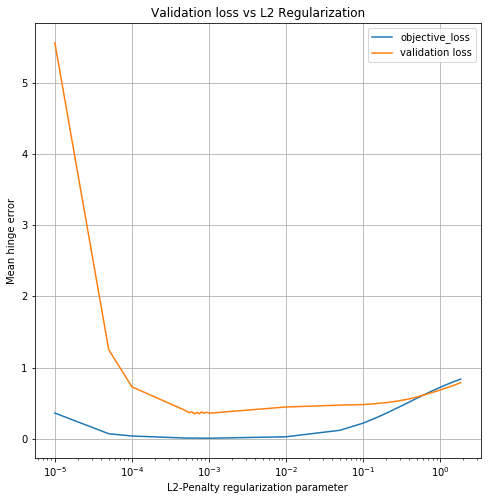

In [34]:
fig, ax = plt.subplots(figsize = (8,8))
x1, y1 = zip(*sorted(traindic.items()))
x2, y2 = zip(*sorted(testdic.items()))
ax.semilogx(x1,y1,label="objective_loss")
ax.semilogx(x2,y2,label="validation loss")
ax.grid()
ax.set_title("Validation loss vs L2 Regularization")
ax.set_xlabel("L2-Penalty regularization parameter")
ax.set_ylabel("Mean hinge error")
ax.legend()
fig.show()